**Predicting heart disease in patients from Cleveland using age, cholesterol, chest pain diagnosis, and resting blood pressure**

Matt Ward, Byeori Kim, Seifeldin Elkemary, Chaitanya Thakral

**INTRODUCTION**

Heart disease, also known as cardiovascular disease, is a prevalent and potentially life-threatening condition that affects the heart and blood vessels. There are several types of heart diseases such as: heart failure, arrhythmias, valvular heart disease, and coronary artery disease, being the most common out of the four. The earlier the diagnosis of these diseases, the better the treatment becomes. Hence, our goal of this project is to be able to classify new patients on their likelihood of having a heart disease based on several risk factors that play into the possibility.

Can we determine if a new patient is at risk of heart disease based on their age, cholesterol level, resting blood pressure, and presence of chest pain? 
This question will be addressed using a dataset from Cleveland, since it has the variables of the risk factors that play in diagnosing a heart disease. The dataset has age(years), cholesterol levels(mg/dl),  resting blood pressure(mmHg), and presence of chest pain in its data of many instances of patients. 


**Preliminary Exploratory Data Analysis**

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [86]:
set.seed(4)
cleveland_data<-read_csv("https://raw.githubusercontent.com/byuly/dsci-100-group-project/main/processed.cleveland.data",
                col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))


cleveland_data[cleveland_data =="?"]<-NA


cleveland_tidy<-cleveland_data|>
                    mutate(diagnosis=ifelse(is.na(num),NA,(num > 0)))|>
                    mutate(sex= as.factor(sex),cp= as.factor(cp), fbs= as.factor(fbs),restecg= as.factor(restecg),exang= as.factor(exang),thal= as.factor(thal),ca= as.factor(ca),slope= as.factor(slope))|>
                    mutate(sex= fct_recode(sex,"M" = "1", "F" = "0"))|>
                    mutate(cp= fct_recode(cp,"Typical Angina"="1", "Atypical Angina"="2","Non-Anginal Pain"="3","Asymptomatic"="4"))
                   


cleveland_split<-initial_split(cleveland_tidy,prop = 0.75, strata = num)
cleveland_testing<-training(cleveland_split)
cleveland_training<-testing(cleveland_split)
                    
cleveland_training

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
56,M,Atypical Angina,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
57,M,Asymptomatic,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE
56,M,Non-Anginal Pain,130,256,1,2,142,1,0.6,2,1.0,6.0,2,TRUE
48,M,Atypical Angina,110,229,0,0,168,0,1.0,3,0.0,7.0,1,TRUE
64,M,Typical Angina,110,211,0,2,144,1,1.8,2,0.0,3.0,0,FALSE
58,F,Typical Angina,150,283,1,2,162,0,1.0,1,0.0,3.0,0,FALSE
60,M,Asymptomatic,130,206,0,2,132,1,2.4,2,2.0,7.0,4,TRUE
50,F,Non-Anginal Pain,120,219,0,0,158,0,1.6,2,0.0,3.0,0,FALSE
58,F,Non-Anginal Pain,120,340,0,0,172,0,0.0,1,0.0,3.0,0,FALSE


In [4]:
cleveland_summary<-cleveland_training|>
                     group_by(diag) |>
                     summarize(min_age = min(age), max_age = max(age),
                              min_chol = min(chol), max_chol = max(chol),
                              min_trestbps = min(trestbps), max_trestbps = max(trestbps),
                              patients = n())
cleveland_summary

diag,min_age,max_age,min_chol,max_chol,min_trestbps,max_trestbps,patients
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,35,76,175,417,101,178,42
TRUE,44,70,149,330,108,200,36


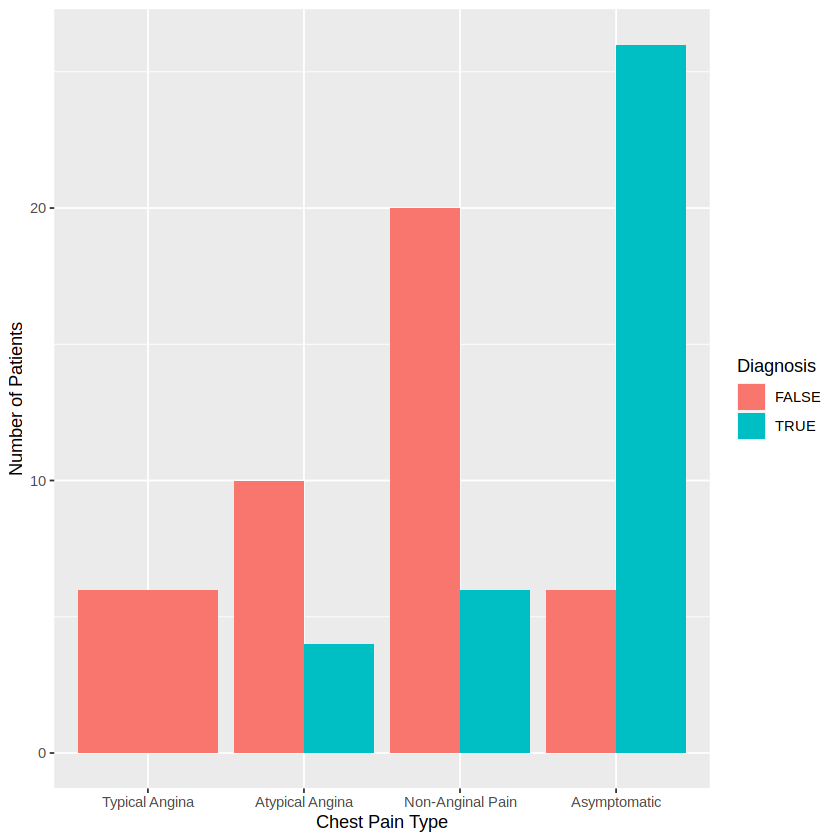

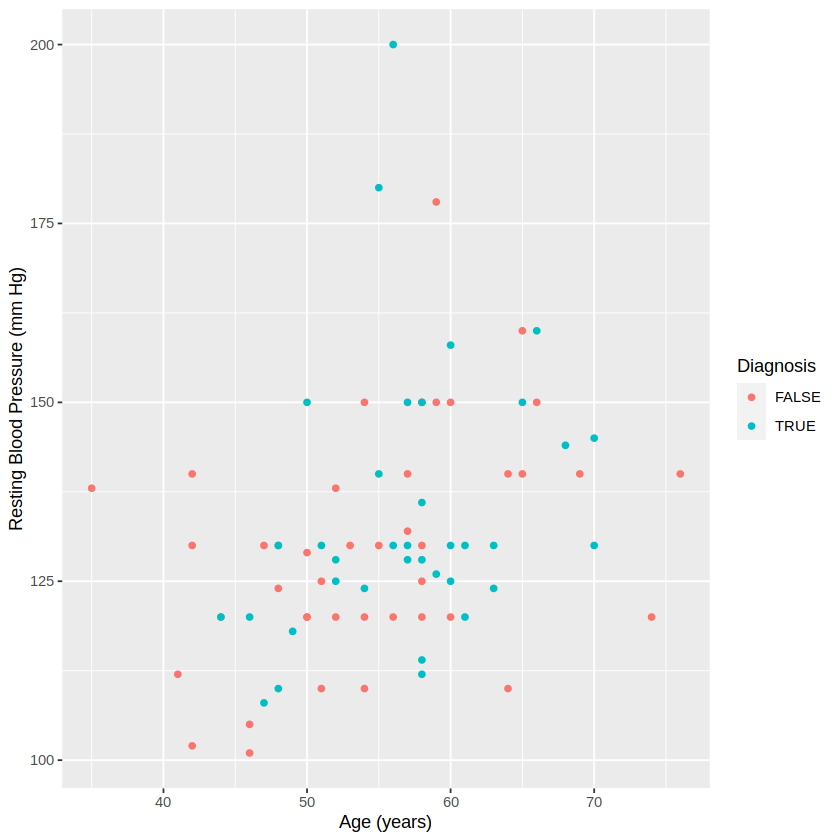

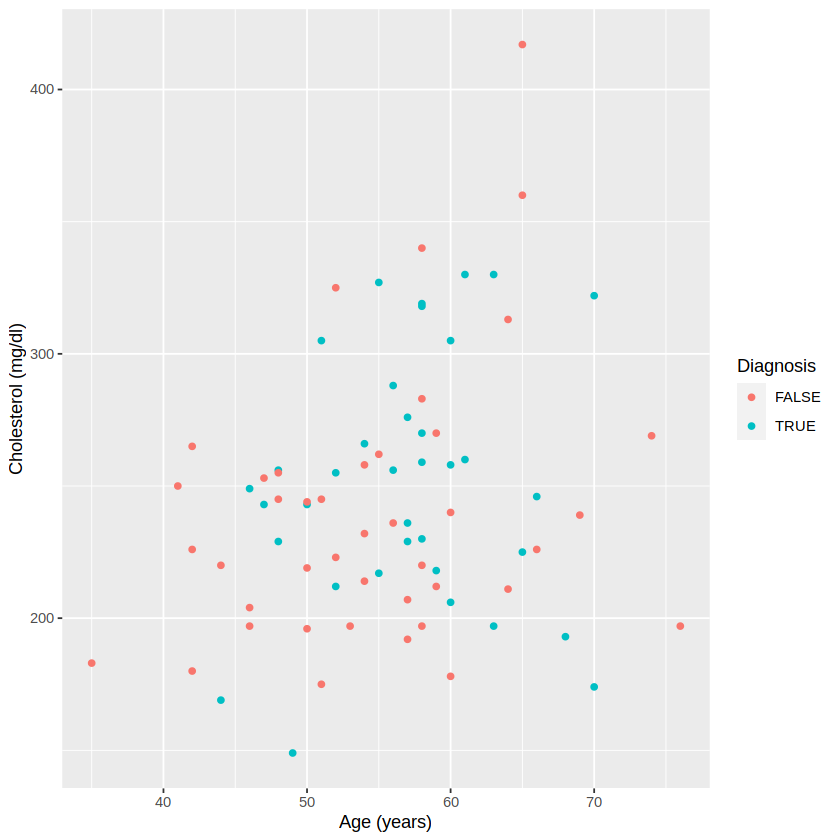

In [87]:
chest_pain_plot<- ggplot(cleveland_training, aes(x = cp, fill = diagnosis)) +
                 geom_bar(position = "dodge") +
                 labs(x = "Chest Pain Type", y = "Number of Patients", fill = "Diagnosis") +
                 scale_color_brewer("Set2")
resting_age_plot <- ggplot(cleveland_training, aes(x = age, y = trestbps, color = diagnosis)) +
                 geom_point(stat= "identity") +
                  labs(x = "Age (years)", y = "Resting Blood Pressure (mm Hg)", color = "Diagnosis")  +
                 scale_fill_brewer("Set2")
cholestrol_age_plot <- ggplot(cleveland_training, aes(x = age, y = chol, color = diagnosis)) +
                 geom_point(stat= "identity") +
                  labs(x = "Age (years)", y = "Cholesterol (mg/dl)", color = "Diagnosis")  +
                 scale_fill_brewer("Set2")
chest_pain_plot
resting_age_plot
cholestrol_age_plot

**METHODS**

To predict whether a patient is afflicted with heart disease of not, we chose to use the "processed.cleveland.data" file from the Heart Disease Database

When diagnosing heart diseases, the key factors considered include the patient's age, chest pain, cholesterol levels, and resting blood pressure. We opted to employ them as classifiers for our prediction model, since according to multiple studies, these are the best indicators available in the dataset for predicting heart disease.

The data was tidied, and since it included occurrences of "?" in place of missing data, they were substituted with NA. A new column “diagnosis” was created to assign “TRUE” for any value above 0 in the column “num"

While building the classification model, we first split the data into training and test sets, in order to ensure that we assess the performance of our method on observations not seen during training. And finally, we used cross-validation to evaluate different choices of model parameters (e.g., K in a K-nearest neighbors model). 

To facilitate a thorough analysis, we computed the minimum and maximum age, cholesterol, and resting blood pressure

We opted to represent our data visually by using a bar graph and scatterplots. For example, a bar graph was generated to illustrate the relationship between the number of patients and different categorical chest pain types.


**EXPECTED OUTCOMES AND SIGNIFICANCE**

From our analysis, we expect to find correlations between age, cholesterol levels, chest pain, and resting blood levels with the presence of an individual having heart disease. Additionally, we want to be able to anticipate key factors that contribute to the likelihood of heart disease in a patient.

These findings could have significant implications for early detection and prevention of heart disease.

Given ample time, a thorough and in-depth analysis of the following questions could be explored.
       
        1. What additional factors not considered in this analysis might also be relevant to predicting heart disease?
        2. How can technology and machine learning be further leveraged to enhance predictive models?
